In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) 

import numpy as np
import random


np.random.seed(42)
random.seed(42)

import features_extraction as ta 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
aapl = pd.read_csv('AAPL.csv')
del(aapl['Date'])
del(aapl['Adj Close'])
aapl.head()

,Open,High,Low,Close,Volume
0,33.641430,33.801430,33.494286,33.571430,107664900
1,33.915714,34.104286,33.250000,33.709999,150786300
2,33.568573,34.072857,33.538570,34.070000,171126900
3,34.028572,34.320000,33.857143,34.220001,111754300
4,34.221428,34.560001,34.094284,34.371429,157125500


In [3]:
def get_exp_preprocessing(df, alpha=0.9):
    edata = df.ewm(alpha=alpha).mean()    
    return edata

In [4]:
saapl = get_exp_preprocessing(aapl)
saapl.head() #saapl stands for smoothed aapl

,Open,High,Low,Close,Volume
0,33.641430,33.801430,33.494286,33.571430,1.076649e+08
1,33.890779,34.076754,33.272208,33.697402,1.468662e+08
2,33.600503,34.073243,33.512174,34.033076,1.687227e+08
3,33.985804,34.295347,33.822677,34.201325,1.174460e+08
4,34.197868,34.533538,34.067126,34.354420,1.531579e+08


In [5]:
def feature_extraction(data):
    for x in [5, 14, 26, 44, 66]:
        data = ta.relative_strength_index(data, n=x)
        data = ta.rate_of_change(data, n=x)
        data = ta.on_balance_volume(data, n=x)
       
    #%K
    data['SO%k'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])
  
    #Williams %R 
    data['ema14'] = data['Close'] / data['Close'].ewm(14).mean()
       
    
    data = ta.macd(data, n_fast=12, n_slow=26)
    
    del(data['Open'])
    del(data['High'])
    del(data['Low'])
    del(data['Volume'])
    
    return data
   
def compute_prediction_int(df, n):
    pred = (df.shift(-n)['Close'] >= df['Close'])
    pred = pred.iloc[:-n]
    return pred.astype(int)

def prepare_data(df, horizon):
    data = feature_extraction(df).dropna().iloc[:-horizon]
    data['pred'] = compute_prediction_int(data, n=horizon)
    del(data['Close'])
    return data.dropna()

In [7]:
data = prepare_data(saapl, 10)

y = data['pred']

features = [x for x in data.columns if x not in ['gain', 'pred']]
X = data[features]


In [8]:
data.head()

,RSI_5,ROC_5,OBV_5,RSI_14,ROC_14,OBV_14,RSI_26,ROC_26,OBV_26,RSI_44,...,OBV_44,RSI_66,ROC_66,OBV_66,SO%k,ema14,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,pred
65,0.026348,-0.078440,-1.495358e+08,0.223650,-0.046336,-3.733386e+07,0.335539,-0.021026,-1.157488e+07,0.380961,...,-4.316442e+07,0.398649,0.051618,-2.055270e+07,0.477091,0.955694,-0.028637,0.328496,-0.357133,0.0
66,0.172966,-0.034540,-1.473860e+08,0.264503,-0.067403,-3.662660e+07,0.353693,-0.031025,-1.215478e+07,0.390852,...,-4.224040e+07,0.405494,0.053409,-1.818097e+07,0.384506,0.963449,-0.141125,0.234564,-0.375688,1.0
67,0.577230,0.021962,-6.088403e+07,0.414899,-0.050404,-3.863104e+07,0.425461,-0.010521,-1.360655e+07,0.431124,...,-3.457277e+07,0.433626,0.081515,-1.793760e+07,0.942300,0.999075,-0.123647,0.162917,-0.286563,0.0
68,0.730475,0.036982,1.425800e+07,0.505393,-0.057523,-4.099648e+07,0.474345,-0.021047,-1.494880e+07,0.460091,...,-2.551554e+07,0.454267,0.077845,-1.773074e+07,0.458529,1.000566,-0.104062,0.109518,-0.213580,1.0
69,0.730475,0.049902,8.730203e+07,0.505393,-0.040919,-4.687891e+07,0.474345,-0.014078,-1.729171e+07,0.460091,...,-1.581854e+07,0.454267,0.078932,-1.775666e+07,0.864039,1.005649,-0.071458,0.073321,-0.144779,1.0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 2*len(X) // 3)

print('len X_train', len(X_train))
print('len y_train', len(y_train))
print('len X_test', len(X_test))
print('len y_test', len(y_test))

len X_train 732
len y_train 732
len X_test 366
len y_test 366


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=42)
rf.fit(X_train, y_train.values.ravel());

In [11]:
pred = rf.predict(X_test)
precision = precision_score(y_pred=pred, y_true=y_test)
recall = recall_score(y_pred=pred, y_true=y_test)
f1 = f1_score(y_pred=pred, y_true=y_test)
accuracy = accuracy_score(y_pred=pred, y_true=y_test)
confusion = confusion_matrix(y_pred=pred, y_true=y_test)
print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy: {3:1.2f}'.format(precision, recall, f1, accuracy))
print('Confusion Matrix')
print(confusion)

precision: 0.81, recall: 0.89, f1: 0.85, accuracy: 0.81
Confusion Matrix
[[104  44]
 [ 25 193]]


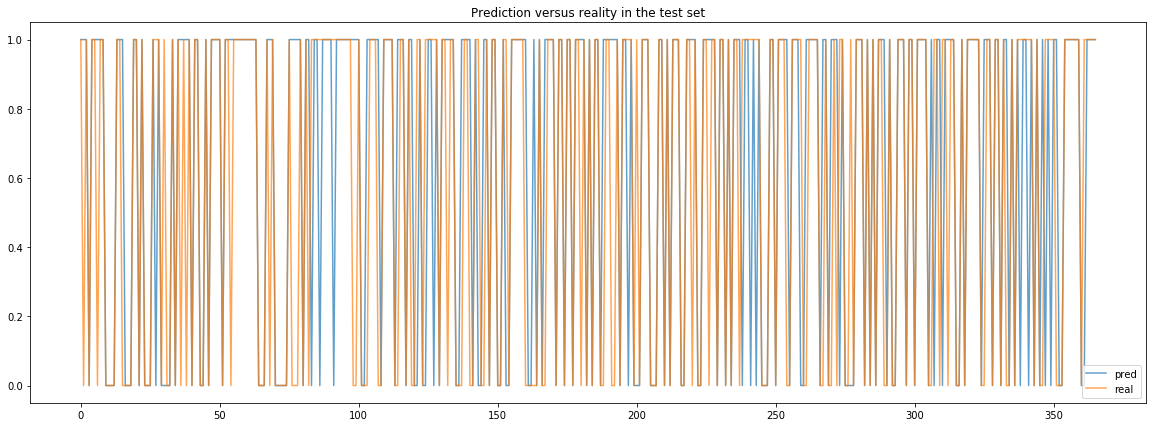

In [13]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(pred)), pred, alpha=0.7, label='pred')
plt.plot(np.arange(len(y_test)), y_test, alpha=0.7, label='real' );
plt.title('Prediction versus reality in the test set')
plt.legend();